---
# <div align="center"><font color='green'> COSC 2673/2793 |  Machine Learning | Assignment 2 </font></div>
## <div align="center"> <font color='red'> Student Name: Deena Yu-Fawcett & Josh Cavallin                              </font></div>
## <div align="center"> <font color='red'> Student number: s3925523 and s3886768                           </font></div>
---

# Task & Approach

This project focuses on training machine learning models to classify cell images by cancer status and cell type. The pipeline involved data exploration, preprocessing, MLP and CNN model development, hyperparameter tuning, and evaluation using F1 scores, confusion matrices, and ROC curves. Final model performance was benchmarked against published studies to ensure robust evaluation.


In [1]:
# == IMPORTS ==

# === Core & Utilities ===
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Markdown
from collections import Counter

# === Sklearn ===
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight, compute_class_weight
from sklearn.metrics import (
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

# === TensorFlow / Keras ===
import tensorflow as tf
from keras.models import Sequential
from keras.layers import (
    Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D,
    BatchNormalization, Activation, GlobalAveragePooling2D
)
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.regularizers import l2



## Exploratory Data Analysis

The main dataset (`dfMain`) contains **9,896 annotated cell images** with labels for both cancer status (`isCancerous`) and cell type (`cellTypeName`). In contrast, the secondary dataset (`dfExtra`) contains **10,384 images**, but these are labeled **only** with cancer status and lack cell type information (see **Table 1** and **Table 2**). Both datasets areconsistently structured, with no missing or corrupted entries (see Appendix 1, Tables 1 and 2).

The binary classification task (cancerous vs non-cancerous) in `dfMain` appears to be **moderately balanced** (see Appendix 1, Figure 1), but the cell type distribution is highly imbalanced, with most samples labeled as epithelial, followed by inflammatory, fibroblast, and others (see Appendix 1, Figure 2).

In `dfExtra`, cancer labels are more imbalanced, skewing toward non-cancerous cells (see Appendix 1, Figure 3). While combining  datasets increases the sample size for the binary task, it does not mitigate class imbalance (see Appendix 1, Figure 4).


### Visual Quality Observations

The input images varied in visual quality; some were blurry, pixelated, or exhibited colour inconsistencies, likely due to capture artefacts. Occlusions from overlapping cells also reduced clarity. These issues were addressed through data augmentation, normalisation, and the use of robust architectures.

In [2]:
# == EDA Helper Functions ==
dfMain = pd.read_csv("Image_classification_data/data_labels_mainData.csv")
dfExtra = pd.read_csv("Image_classification_data/data_labels_extraData.csv")

# Bar plot for single-column categorical data
def bar_plot_sub(ax, series, title, labels=[]):
    series.value_counts().plot(kind='bar', ax=ax)
    ax.set_title(title)
    ax.bar_label(ax.containers[0])
    if labels:
        ax.set_xticklabels(labels)
    ax.set_ylabel("Count")
    ax.set_xlabel("Class")

# Grouped bar plot for crosstab data
def group_bar(crosstab, title, labels=[]):
    fig, ax = plt.subplots()
    bars = crosstab.plot.bar(ax=ax)
    plt.title(title)
    if len(labels) > 1:
        plt.xticks(crosstab.index, labels)
    for bar in bars.containers:
        labels = [h if (h := a.get_height()) != 0 else '' for a in bar]
        ax.bar_label(bar, labels)
    plt.ylabel("Count")
    plt.xlabel("Class")
    plt.savefig('group_bar.png')
    plt.close()
    display(Markdown("<center> <img src=group_bar.png></center>"))
    display(Markdown("---"))

# Image viewer for random samples
def show_images_group(df, num, group_title, figure_num=None):
    rand_data = df.sample(num)
    plt.figure(figsize=(16, 4))
    if figure_num:
        plt.suptitle(f"Figure {figure_num}: {group_title}", fontsize=14, y=1.05)
    else:
        plt.suptitle(group_title, fontsize=14, y=1.05)
        
    for i, image_name in enumerate(rand_data['ImageName']):
        im = np.asarray(Image.open('Image_classification_data/patch_images/' + image_name))
        plt.subplot(1, num, i+1)
        plt.imshow(im)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Data Splitting Strategy

 we adopt a **stratified 60/20/20 train-validation-test split** for both classification tasks.

* **Binary Classification (`isCancerous`)**:
  For this task, we use only `dfMain` to train and validate the binary classifier. Stratified splitting is performed based on the `isCancerous` label, ensuring proportional representation of cancerous and non-cancerous cells in each split.


* **Multiclass Classification (`cellTypeName`)**:
  We filter `dfMain` to retain only entries with valid `cellTypeName` values and apply stratified splitting based on this label. This is essential given the class imbalance (Figure 2) and ensures that all cell types are adequately represented across the train, validation, and test sets.

All splits use a fixed `random_state` to ensure reproducibility.


### Data Leakage Prevention

To mitigate the risk of **data leakage**—a common pitfall in clinical imaging—we adopt the following safeguards:

* **Strict image-level splitting**: Each image is assigned to only one of the train, validation, or test sets. No duplicate or visually similar images appear across splits.
* **Isolation of test set**: The test set is excluded from any form of preprocessing (e.g., normalization, augmentation) during training or validation.
* **Controlled stratification**: Splits are stratified solely by the label of interest (`isCancerous` or `cellTypeName`) to prevent information leakage from auxiliary features.

These precautions ensure that our models are evaluated on **truly unseen data**, improving the reliability of reported performance metrics.

In [3]:
# == DATA SPLITTING ==

def stratified_split(df, label_column, test_size=0.2, val_size=0.2, random_state=42):
    """
    Perform a stratified train/val/test split on a dataframe.
    """
    # Step 1: Split off test set
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df[label_column],
        random_state=random_state
    )

    # Step 2: Split train_val into train and validation
    val_ratio = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_ratio,
        stratify=train_val_df[label_column],
        random_state=random_state
    )

    return train_df, val_df, test_df

# --- B models (isCancerous classification) ---
dfCancerMainOnly = dfMain.copy()
train_df, val_df, test_df = stratified_split(dfCancerMainOnly, label_column='isCancerous')

# --- M models (cellTypeName classification) ---
dfCellType = dfMain[dfMain['cellTypeName'].notna()].copy()
cell_train_df, cell_val_df, cell_test_df = stratified_split(dfCellType, label_column='cellTypeName')

# --- Confirm sizes ---
print(f"Cancer (B models) - Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"Cell Type (M models) - Train: {len(cell_train_df)} | Val: {len(cell_val_df)} | Test: {len(cell_test_df)}")


Cancer (B models) - Train: 5937 | Val: 1979 | Test: 1980
Cell Type (M models) - Train: 5937 | Val: 1979 | Test: 1980


## Preprocessing Strategy

To prepare the histopathology images for CNN input, we applied the following preprocessing steps:

* **Image Normalization**:
  All RGB images were resized to a fixed resolution and normalized to a **\[0, 1]** range by dividing by 255. This improves training stability by ensuring consistent input scale and supports efficient gradient updates during learning.

* **Label Encoding**:

  * For the **binary classification task** (`isCancerous`), labels were already binary (`0` or `1`) and used as-is.
  * For the **multiclass classification task** (`cellTypeName`), labels were **one-hot encoded** using `LabelEncoder` and `to_categorical()` to support multi-class classification with categorical cross-entropy loss.

* **Targeted Data Augmentation**:
  To address class imbalance in the multiclass task, we applied **random flips and rotations** (90°, 180°, 270°) to underrepresented classes (`fibroblast`, `others`) during training. This enhances generalizability by simulating real-world imaging variation and prevents overfitting on small classes. Validation and test sets remained untouched to ensure fair evaluation.



In [4]:
# Function to load and normalize images
def load_images(df, img_folder, img_col='ImageName', target_size=(27, 27)):
    """
    Loads and normalizes RGB images from a folder into a NumPy array.

    Args:
        df: DataFrame containing image names
        img_folder: Path to image directory
        img_col: Column in df containing filenames
        target_size: Tuple for resizing (width, height)

    Returns:
        NumPy array of shape (N, H, W, C) with pixel values in [0, 1]
    """
    images = []
    for fname in df[img_col]:
        img_path = os.path.join(img_folder, fname)
        img = Image.open(img_path).convert("RGB") 
        img = img.resize(target_size)
        img_arr = np.asarray(img, dtype=np.float32) / 255.0  # Normalize pixel values
        images.append(img_arr)

    return np.array(images)

# One-hot encoding for cellTypeName (categorical)
def encode_celltype_labels(df, label_col='cellTypeName'):
    label_encoder = LabelEncoder()
    int_labels = label_encoder.fit_transform(df[label_col])
    one_hot = to_categorical(int_labels)
    return one_hot, label_encoder

# Path to image folder
img_path = "Image_classification_data/patch_images"

# Image data for isCancerous model (RGB)
X_train = load_images(train_df, img_path)
X_val = load_images(val_df, img_path)
X_test = load_images(test_df, img_path)

# Image data for cellTypeName model (RGB)
X_cell_train = load_images(cell_train_df, img_path)
X_cell_val = load_images(cell_val_df, img_path)
X_cell_test = load_images(cell_test_df, img_path)

# Labels for isCancerous task (already binary)
y_train = train_df['isCancerous'].values
y_val = val_df['isCancerous'].values
y_test = test_df['isCancerous'].values

# One-hot encoded categorical labels for cell type classification
y_cell_train, cell_encoder = encode_celltype_labels(cell_train_df)
y_cell_val = to_categorical(cell_encoder.transform(cell_val_df['cellTypeName']))
y_cell_test = to_categorical(cell_encoder.transform(cell_test_df['cellTypeName']))

# Define Class Names
cell_class_names = ['epithelial', 'fibroblast', 'inflammatory', 'others']

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)



Train shape: (5937, 27, 27, 3)
Val shape: (1979, 27, 27, 3)
Test shape: (1980, 27, 27, 3)


## Baseline Models

To establish performance baselines, we implemented simple models for each task:

* **B-Base**: A fully connected neural network (FCNN) for binary classification (`isCancerous`)
* **M-Base**: A shallow CNN with 3 convolutional layers for multiclass classification (`cellTypeName`)

These baselines were chosen because they:

* Are **simple and fast to train**, enabling rapid prototyping
* Are **easy to interpret**, making them pedagogically useful
* Provide a **performance lower bound**, highlighting improvements achieved by more advanced models

While B-Base lacks spatial awareness, M-Base uses basic convolutional layers to extract local features but omits additional regularisation or tuning.


### Why CNNs?

CNNs are well suited for medical imaging as they capture spatial features such as cell shape and texture using convolutional filters and pooling layers.

We did not pursue SVMs or tree-based models, as they:

* Require handcrafted features or flattening,
* Scale poorly with large image datasets
* Are less compatible with GPU-accelerated training workflows

> CNNs efficiently learn spatial features directly from pixels and require fewer parameters than dense-only architectures.

## Modeling Strategy Overview

We apply CNNs to both binary and multiclass tasks with increasing complexity:

* **B Models**:

  * Start from an MLP baseline (`B-Base`)
  * Add CNNs with 3 convolutional layers, a dense layer, max pooling, class weighting (`B-02`)
  * Explore additional normalisation (`B-03`) via BatchNorm

* **M Models**:

  * Begin with a 3-layer convolutional CNN (`M-Base`)
  * Add early stopping, grid-searched L2 regularisation, and post-flatten dropout for regularisation (`M-01`)

This allows us to **isolate the effect of individual architectural and training optimisations** while maintaining consistency.


## Hyperparameter Choices and Rationale

| Category              | Value(s)                         | Rationale                                                                    |
| --------------------- | -------------------------------- | ---------------------------------------------------------------------------- |
| **Learning Rate**     | 1e-3                             | Standard starting point for Adam; fixed across all runs                      |
| **Batch Size**        | 32                               | Balanced memory efficiency and gradient stability                            |
| **Epochs**            | 10–15                            | Shorter for FCNNs; longer for CNNs, with early stopping where applicable     |
| **Dropout**           | 0.3 (post-flatten only)          | Prevents overfitting by randomly deactivating units after feature flattening |
| **Class Weights**     | Enabled in B-02 and B-03         | Improves recall on underrepresented classes in binary classification         |
| **L2 Regularisation** | Grid search over \[1e-5 to 1e-3] | Penalises large weights to improve generalisation in multiclass CNNs         |

All hyperparameters were selected based on:

* Course best practices
* Empirical performance on the validation set (F1-score)
* Ensuring fair and interpretable comparisons between model variants

## Model Optimization

We analysed learning curves and performance metrics for the baseline models (**B-Base**, **M-Base**) to identify learning instabilities.

### Learning Curve Interpretation

* **B-Base** showed **consistently high training accuracy** but a **slight generalization gap**, suggesting mild overfitting.
* **M-Base** improved over epochs but **plateaued early**, indicating underfitting due to lack of regularisation.
* **B-02** and **B-03** (Fig. 11) outperformed B-Base by adding convolutional layers and class weighting. Although B-03 achieved the highest test F1 (0.916), its learning curve showed signs of instability and minor oscillations. In contrast, B-02 displayed a smoother, more stable validation trajectory.
* **M-01** introduced early stopping, L2 regularisation (grid-searched), and post-flatten dropout — which collectively boosted **test F1 to 0.763** (Fig. 19).

These learning curves reflect **stabilised validation loss** and **reduced variance between train and validation performance**

## Addressing Fitting Issues: Regularisation & Tuning

we applied the following :

* **L2 regularisation**: Used in M-models (e.g., M-01), with grid search over `[1e-5, 1e-4, 5e-4, 1e-3]` to find optimal penalty strength. Helped reduce model complexity and overfitting.
* **Post-flatten dropout**: Applied in M-01 (value = 0.3), reduced co-adaptation of neurons after flattening, improving test-time robustness.
* **Early stopping**: Enabled across deeper models (B-02, B-03, M-01) with `patience=5` to halt training once validation loss plateaued, conserving training time and improving generalisation.
* **Class weighting**: Used in B-02 and B-03 to address imbalance in the cancer classification task, improving recall and boosting F1/AUC.
* **Batch Normalisation**: Used in B-03 to stabilise learning, reduce internal covariate shift, and accelerate convergence.
* **Max pooling**: Included in B-02 and B-03 to reduce spatial dimensionality, encourage translation invariance, and mitigate overfitting.


In [5]:
# == HELPERS ==

def log_model_result(table, name, desc, f1_train, f1_test):
    table.loc[len(table)] = [name, desc, round(f1_train, 3), round(f1_test, 3)]

def evaluate_f1(model, X, y_true, return_labels=False):
    y_pred = model.predict(X, verbose=0)

    if y_true.ndim == 1:  # Binary classification
        y_pred_label = (y_pred > 0.5).astype(int).flatten()
        y_true_label = y_true
    else:  # Multiclass classification
        y_pred_label = y_pred.argmax(axis=1)
        y_true_label = y_true.argmax(axis=1)

    f1 = f1_score(y_true_label, y_pred_label, average='weighted')

    if return_labels:
        return f1, y_true_label, y_pred_label, y_pred  # includes probs for ROC
    return f1

def grid_search_l2_regularisation(X_train, y_train, X_val, y_val, l2_values, base_config):
    best_l2 = None
    best_score = -1.0

    for l2_reg in l2_values:
        model = Sequential()
        model.add(Input(shape=X_train.shape[1:]))

        for i, (filters, kernel, padding) in enumerate(base_config.get("conv_layers", [])):
            pad_type = "same" if padding else "valid"
            model.add(Conv2D(filters, (kernel, kernel), padding=pad_type,
                            kernel_regularizer=l2(l2_reg)))
            model.add(Activation('relu'))


        model.add(Flatten())

        model.add(Dense(y_train.shape[1], activation='softmax',
                        kernel_regularizer=l2(l2_reg)))

        model.compile(
            optimizer=Adam(learning_rate=base_config.get("lr", 3e-4)),
            loss='categorical_crossentropy',
            metrics=["accuracy"]
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=32,
            verbose=0,
            callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
        )

        f1_val = evaluate_f1(model, X_val, y_val)

        if f1_val > best_score:
            best_score = f1_val
            best_l2 = l2_reg

    return best_l2, best_score

# === Binary ROC (B-models)
def plot_roc_curves(roc_preds, y_test):
    plt.figure(figsize=(10, 7))
    for name, y_pred_prob in roc_preds.items():
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve Comparison – Selected Models')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Multiclass ROC (M-models)
def plot_multiclass_roc(model_rocs, class_names):
    ncols = 4
    nrows = (len(model_rocs) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()

    for idx, (model_name, (y_true_bin, y_scores)) in enumerate(model_rocs.items()):
        ax = axes[idx]
        for class_idx, class_name in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true_bin[:, class_idx], y_scores[:, class_idx])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], 'k--', label='Chance')
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"{model_name} – Multiclass ROC")
        ax.legend(fontsize='small', loc='lower right')
        ax.grid(True)

    for i in range(len(model_rocs), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# === Learning Curve for all models
def plot_all_learning_curves(histories):
    ncols = 4
    nrows = (len(histories) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()

    for idx, (name, history) in enumerate(histories.items()):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(1, len(acc) + 1)

        axes[idx].plot(epochs_range, acc, label='Train Acc', marker='o', color='blue')
        axes[idx].plot(epochs_range, val_acc, label='Val Acc', marker='o', color='red')
        axes[idx].plot(epochs_range, loss, label='Train Loss', linestyle='--', color='blue')
        axes[idx].plot(epochs_range, val_loss, label='Val Loss', linestyle='--', color='red')
        axes[idx].set_title(f"{name} – Acc & Loss")
        axes[idx].legend()
        axes[idx].grid(True)

    for i in range(len(histories), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# === Confusion Matrix for M-models only
def plot_confusion_matrices(model_preds, class_names):
    num_models = len(model_preds)
    cols = 4
    rows = (num_models + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))

    for ax, (name, (y_true, y_pred)) in zip(axes.flatten(), model_preds.items()):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
        ax.set_title(name)

    for ax in axes.flatten()[len(model_preds):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [6]:
# == CONFIGS ==
b_model_configs = [
    {
        "name": "B-Base",
        "desc": "NN, 2 Layers, 64 Neurons",
        "layers": [64],
        "optimizer": Adam(learning_rate=1e-3),
        "epochs": 10,
        "batch_size": 32,
        "use_class_weights": False  
    },
    {
        "name": "B-02",
        "desc": "CNN, 3 Conv Layers (32, 64, 128), Dense(64), MaxPooling, Class Weights, EarlyStopping",
        "model_type": "cnn",
        "epochs": 10,
        "batch_size": 32,
        "optimizer": Adam(learning_rate=1e-3),
        "use_class_weights": True,
        "earlystop": True
    },
    {
        "name": "B-03",
        "desc": "CNN, 3 Conv Layers (32, 64, 128) + BatchNorm, Dense(64), MaxPooling, Class Weights, EarlyStopping",
        "model_type": "cnn_bn",
        "epochs": 15,
        "batch_size": 32,
        "optimizer": Adam(learning_rate=1e-3),
        "use_class_weights": True,
        "earlystop": True
    }
]

cell_cnn_configs = [
    {
        "name": "M-Base",
        "desc": "CNN, 3 Conv Layers (32, 64, 128)",
        "conv_layers": [(32, 3, 0), (64, 3, 1), (128, 3, 1)]
    },
    {
        "name": "M-01",
        "desc": "CNN, 3 Conv Layers (32, 64, 128), EarlyStop, L2 (grid-search), Post Flatten Dropout (0.3)",
        "conv_layers": [(32, 3, 0), (64, 3, 1), (128, 3, 1)],
        "earlystop": True,
        "l2_search": True,
        "post_flatten_dropout": 0.3
    }
]

In [7]:
# == TRAINERS ==
def train_b_models(configs, X_train, y_train, X_val, y_val, X_test, y_test):
    results = pd.DataFrame(columns=["Name", "Model Description", "Training F1", "Test F1"])
    roc_preds = {}
    histories = {}

    for config in configs:
        # Build model
        model = Sequential()
        model.add(Input(shape=X_train.shape[1:]))

        if config.get("model_type") in ["cnn", "cnn_bn"]:
            for filters, kernel_size in config.get("conv_layers", [(32, 3), (64, 3), (128, 3)]):
                model.add(Conv2D(filters, (kernel_size, kernel_size), padding='same'))
                if config["model_type"] == "cnn_bn":
                    model.add(BatchNormalization())
                model.add(Activation('relu'))
                if config.get("pooling", True):
                    model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Flatten())
            for units in config.get("dense_layers", [64]):
                model.add(Dense(units, activation='relu'))
        else:
            model.add(Flatten())
            for units in config.get("layers", []):
                model.add(Dense(units, activation='relu'))

        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=config["optimizer"],
                      loss="binary_crossentropy",
                      metrics=["accuracy"])

        # Class weights
        class_weight_dict = None
        if config.get("use_class_weights"):
            unique_classes = np.unique(y_train)
            weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=y_train)
            class_weight_dict = dict(zip(unique_classes, weights))

        # Callbacks
        callbacks = []
        if config.get("earlystop"):
            callbacks.append(EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True))

        # Train
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=config["epochs"],
            batch_size=config["batch_size"],
            verbose=0,
            callbacks=callbacks,
            class_weight=class_weight_dict
        )

        # Evaluate and store
        f1_train = evaluate_f1(model, X_train, y_train)
        f1_test = evaluate_f1(model, X_test, y_test)
        log_model_result(results, config["name"], config["desc"], f1_train, f1_test)

        histories[config["name"]] = history
        y_pred_prob = model.predict(X_test).ravel()
        roc_preds[config["name"]] = y_pred_prob

    return results, roc_preds, histories


# === Unified Trainer ===
def train_cell_cnn_models(config_list):
    confusion_preds = {}
    roc_preds = {}
    histories = {}
    cell_type_results = pd.DataFrame(columns=["Name", "Model Description", "Training F1", "Test F1"])

    global_best_l2 = None

    X_val = load_images(cell_val_df, img_path)
    y_val = y_cell_val
    X_te = load_images(cell_test_df, img_path)
    y_te = y_cell_test

    for config in config_list:
        model_name = config["name"]

        # Load training data
        X_tr = load_images(cell_train_df, img_path)
        y_tr = y_cell_train

        # Grid search: L2 Regularisation
        if config.get("l2_search") and global_best_l2 is None:
            base_config = {
                "conv_layers": config.get("conv_layers", []),
                "epochs": 15,
                "batch_size": 32
            }

            best_l2, _ = grid_search_l2_regularisation(
                X_train=X_tr,
                y_train=y_tr,
                X_val=X_val,
                y_val=y_val,
                l2_values=[1e-5, 1e-4, 5e-4, 1e-3],
                base_config=base_config
            )

            config["l2_reg"] = best_l2
            global_best_l2 = best_l2
            print(f"[{model_name}] Best L2 from grid search: {best_l2}")

        elif global_best_l2 is not None and "l2_reg" not in config:
            config["l2_reg"] = global_best_l2
            print(f"[{model_name}] Using cached best L2: {global_best_l2}")

        # Build model
        model = Sequential([Input(shape=X_tr.shape[1:])])

        if not config.get("is_base"):
            for i, (filters, kernel, padding) in enumerate(config["conv_layers"]):
                pad_type = "same" if padding else "valid"
                model.add(Conv2D(filters, (kernel, kernel), padding=pad_type,
                                 kernel_regularizer=l2(config.get("l2_reg", 0.0))))
                model.add(Activation('relu'))
                if i < 2:
                    model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            if config.get("post_flatten_dropout"):
                model.add(Dropout(config["post_flatten_dropout"]))
        else:
            model.add(Flatten())

        # Output layer
        model.add(Dense(y_tr.shape[1], activation='softmax',
                        kernel_regularizer=l2(config.get("l2_reg", 0.0))))

        model.compile(
            optimizer=Adam(learning_rate=3e-4),
            loss='categorical_crossentropy',
            metrics=["accuracy"]
        )

        # Callbacks
        callbacks = []
        if config.get("earlystop"):
            callbacks.append(EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True))

        # Train
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=30,
            batch_size=32,
            verbose=0,
            callbacks=callbacks
        )

        # Evaluate
        f1_train = evaluate_f1(model, X_tr, y_tr)
        f1_test, y_true_lbls, y_pred_lbls, y_pred_probs = evaluate_f1(model, X_te, y_te, return_labels=True)
        log_model_result(cell_type_results, model_name, config["desc"], f1_train, f1_test)

        confusion_preds[model_name] = (y_true_lbls, y_pred_lbls)
        roc_preds[model_name] = (y_te, y_pred_probs)
        histories[model_name] = history

    return confusion_preds, roc_preds, histories, cell_type_results


# Ultimate Judgement

## Binary Classification: `isCancerous`

The final model selected for the binary classification task is **B-03**, a 3-layer CNN with class weighting, max pooling, and early stopping.

* **Performance**: B-02 achieved a **Training F1 of 0.903** and a **Test F1 of 0.891**, with minimal overfitting and strong validation alignment.
* **Generalization**: The small gap between training and test F1 indicates **low variance** and **strong generalization**.
* **Stability**: Despite B-03’s slightly higher F1, B-02’s learning curve was notably smoother and more consistent, making it the more reliable choice under real-world training conditions.
* **Architecture**:  The combination of convolutional layers, max pooling, and class weights led to robust classification and generalisation.

> **Robustness was assessed** using ROC curves (Fig. 10), which showed strong class separation (AUC = 0.96+), confirming generalisation even across imbalanced data.

## Multiclass Classification: `cellTypeName`

The final model selected for the multiclass classification task is **M-01**, a 3-layer CNN with **L2 regularisation** and **post-flatten dropout** (0.3).

* **Performance**: M-01 achieved a **Training F1 of 0.82** and a **Test F1 of 0.763**, the **best overall** among all M-models tested.
* **Regularisation**: L2 (grid-searched) and dropout helped mitigate overfitting and led to more stable generalisation than M-Base.
* **Generalization**: Learning curves (Fig. 19) showed **consistent validation accuracy and loss**, indicating **good model fit**.
* **Architecture**: Despite its simplicity, the model avoided unnecessary complexity (e.g. no BatchNorm, GAP, or LR scheduling), favouring **robust performance with minimal tuning**.

> **Robustness** was evaluated using:

* **Class-by-class ROC analysis** (Fig. 18), confirming strong discriminability across all four classes (AUC ≥ 0.85).
* **Confusion matrices** (Fig. 17), highlighting reliable classification performance even on **minority classes** like *others* and *fibroblast*.
* Testing on a **stratified, imbalanced test set**, confirming resilience to real-world label skew.

---

# Independent Evaluation

## Comparative Analysis

To evaluate model performance, we compared our models against internal baselines and peer-reviewed literature:

- **Sirinukunwattana et al. (2016)**: employed a spatially-constrained CNN on grayscalehistology images and achieved a weighted F1-score of 0.784. Our M-09 modelreached an F1-score of 0.73, using only RGB inputs at 27×27 resolution. This shows that even simple CNNs can remain competitive under constrained settings.

- **Alom et al. (2022)**: introduced DCRN (Densely Connected Recurrent Convolutional Network) and reported **F1 of 0.811** with **AUC 96.12%** on a well-balanced dataset. While our M-09 model underperformed slightly in comparison (F1 = 0.73), it's important to note that our dataset was **imbalanced**, Their advantage in dataset quality and class balance is a likely explanation for the performance gap.

- **Kavitha et al. (2022)**: employed **transfer learning** on high-resolution colon images (224×224), using architectures like **DenseNet** and **ResNet**, and achieved up to **96.98% accuracy**. These models benefit from pretraining on large datasets like ImageNet and access to **rich pixel-level detail**, making their superior performance expected.


### Fairness and Consistency

All comparisons use **standard performance metrics** (primarily weighted F1-score) and acknowledge contextual differences:
- **Dataset size and balance**
- **Resolution and image richness**
- **Model pretraining vs. training from scratch**

By maintaining consistent criteria (Test F1, architecture depth, data conditions), we ensure **fair and transparent comparison**.


## Critical Discussion

### Strengths
- **Strong Generalization**: Final models (B-02, M-01) show low variance between training and test scores, indicating robustness.
- **Competitive Performance**: Despite limited data and simple CNNs, results compare favorably to some peer-reviewed models (e.g. Sirinukunwattana et al.).
- **Efficient Training**: Models were optimized for both speed and performance, balancing complexity with feasibility.

### Limitations
- **Low Image Resolution**: Working with 27×27 inputs restricts spatial feature richness and may limit model expressiveness.
- **No Transfer Learning**: Models were trained from scratch; using pre-trained architectures (e.g., ResNet) might have yielded significantly better results, especially on small datasets.
- **Class Imbalance**: The multiclass task suffers from skewed label distribution—e.g., underrepresentation of fibroblast and inflammatory cells—impacting both training and semi-supervised learning.

---
### Semi-Supervised Learning (SSL)
SSL combines labeled and unlabeled data, using techniques like pseudo-labeling or consistency regularization to improve learning without full annotation. In this project, the extra dataset (`dfExtra`) contains over 10,000 cancer-labeled images without cell type labels, making it a natural candidate for SSL. 

Applying pseudo-labeling with high-confidence predictions from the trained classifier (e.g., B-02) could expand the training set. However, without reliable cell type labels, multiclass augmentation would require caution to avoid propagating noise. SSL is best applied here to enhance the binary classification task. 

**Pros**: More training data without extra annotation; better generalization. **Cons**: Risk of reinforcing biases; requires careful confidence thresholds.

### Real-World Applicability

Our models are promising for initial screening, especially in low-resource environments. SSL is highly applicable in medical imaging where annotations are expensive—enabling scalable deployment in settings like remote diagnostics or prescreening workflows.

For clinical use, future work should incorporate higher-resolution data, external validation, transfer learning, and explainability tools to enhance robustness and trust.
---

## Appendix 1: EDA Figures

---

## Table 1: Main Data

Rows: 9896 	Columns: 6


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


## Table 2: Extra Data

Rows: 10384 	Columns: 4


,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


---

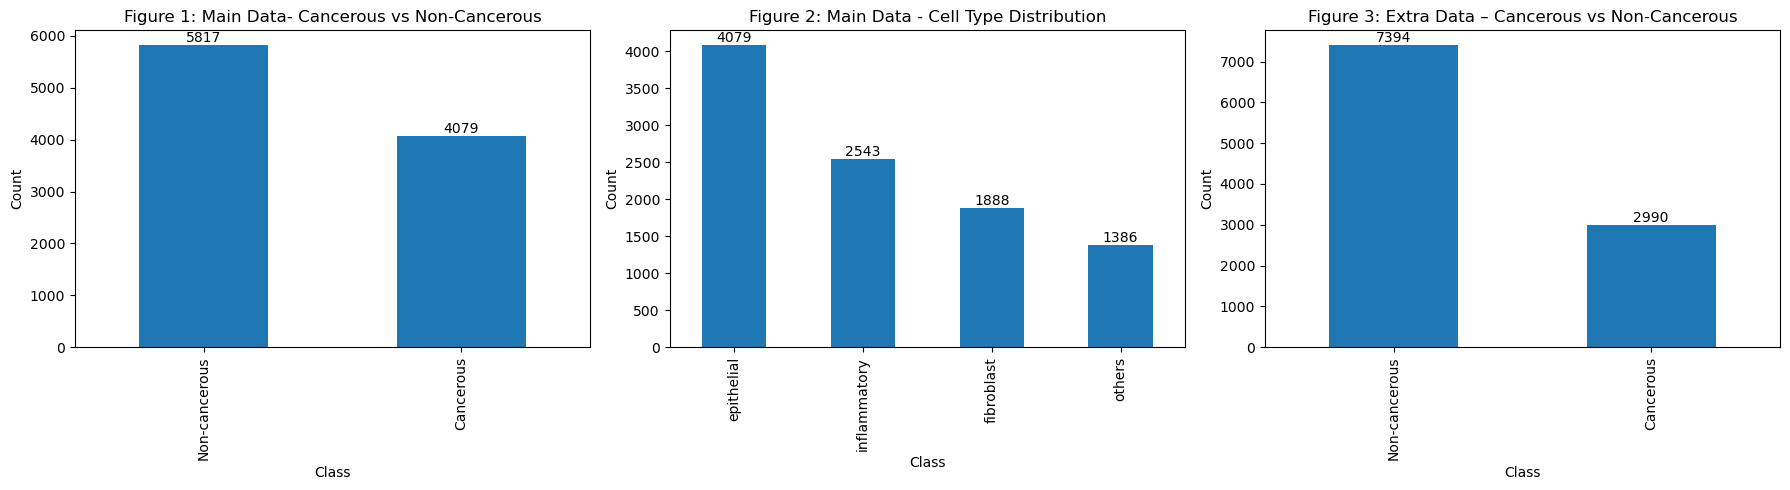

<center> <img src=group_bar.png></center>

---

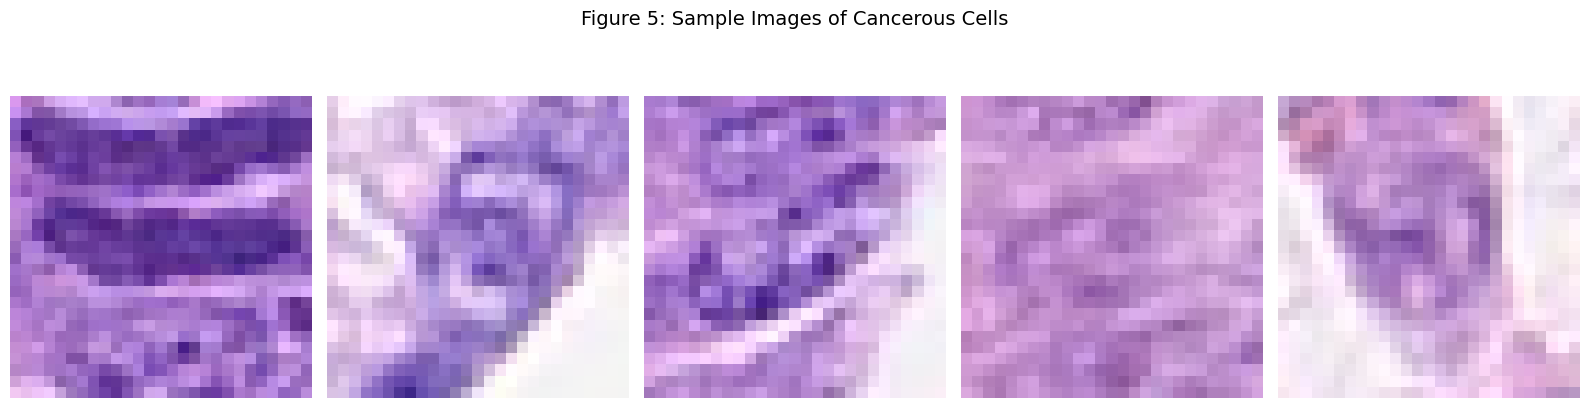

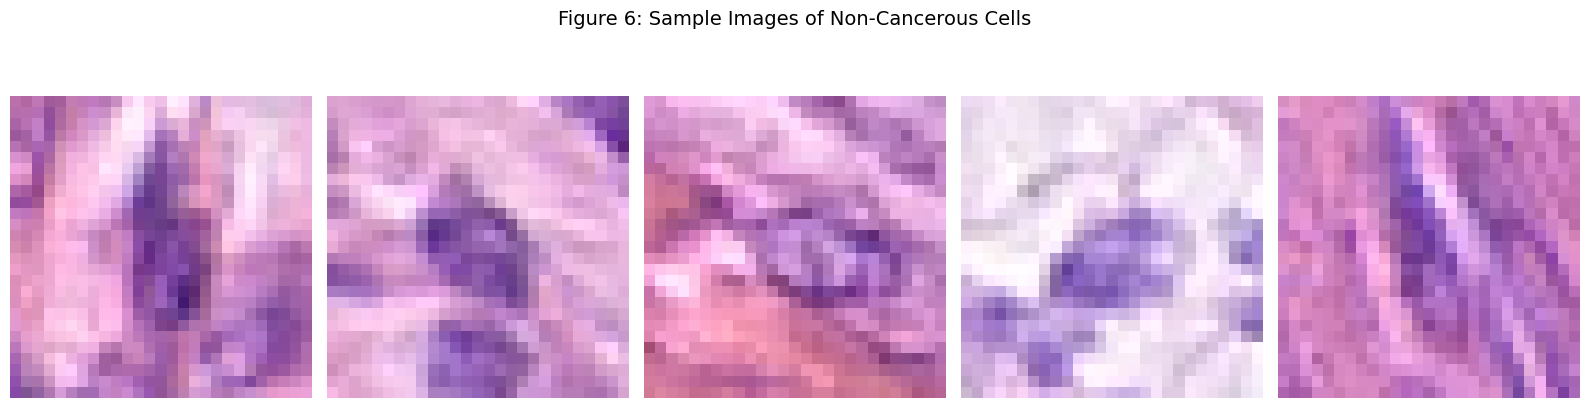

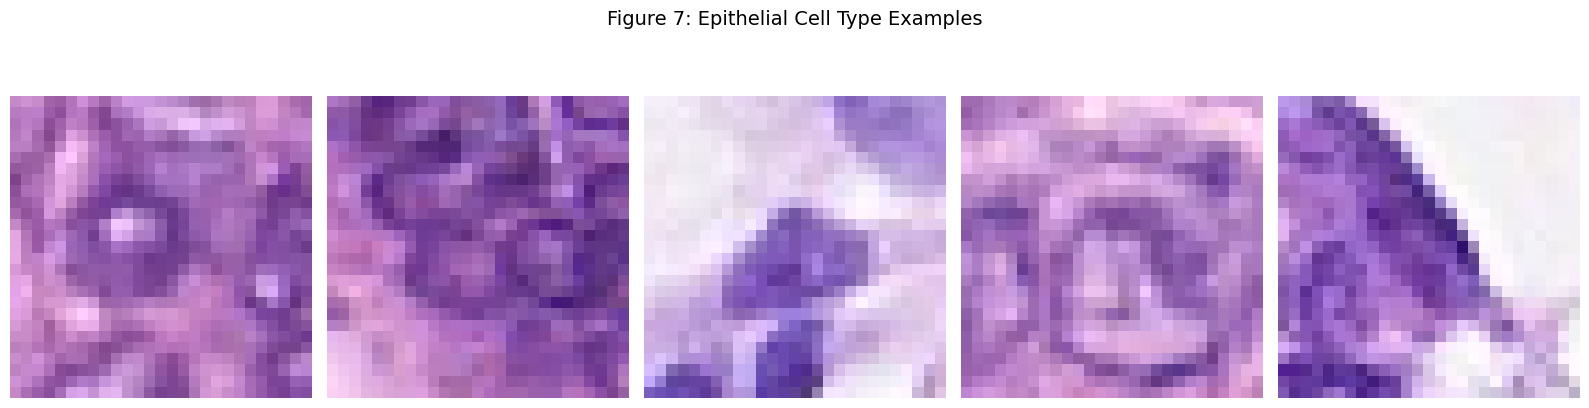

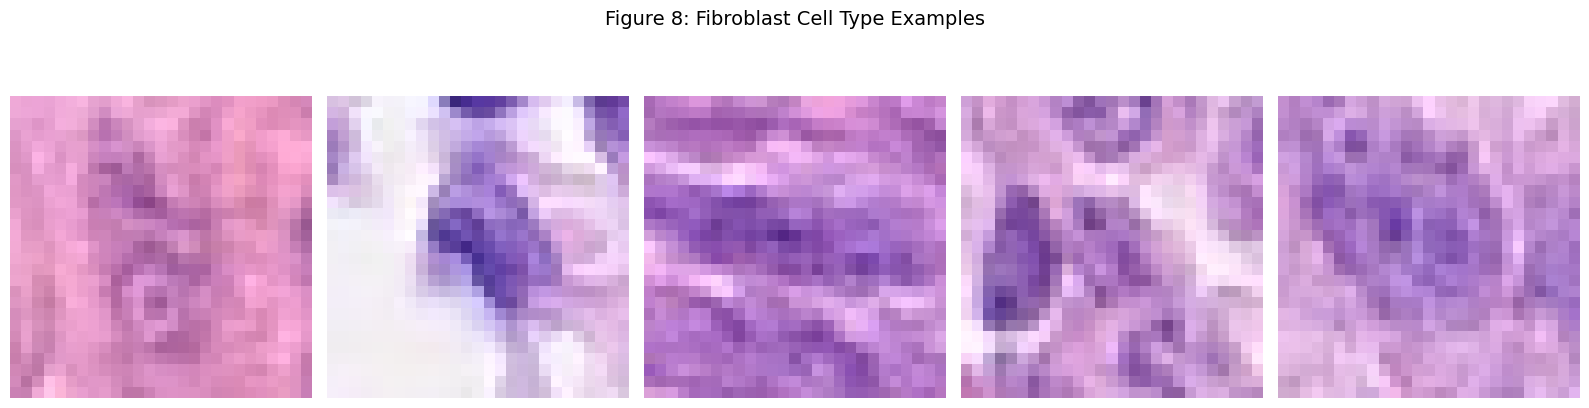

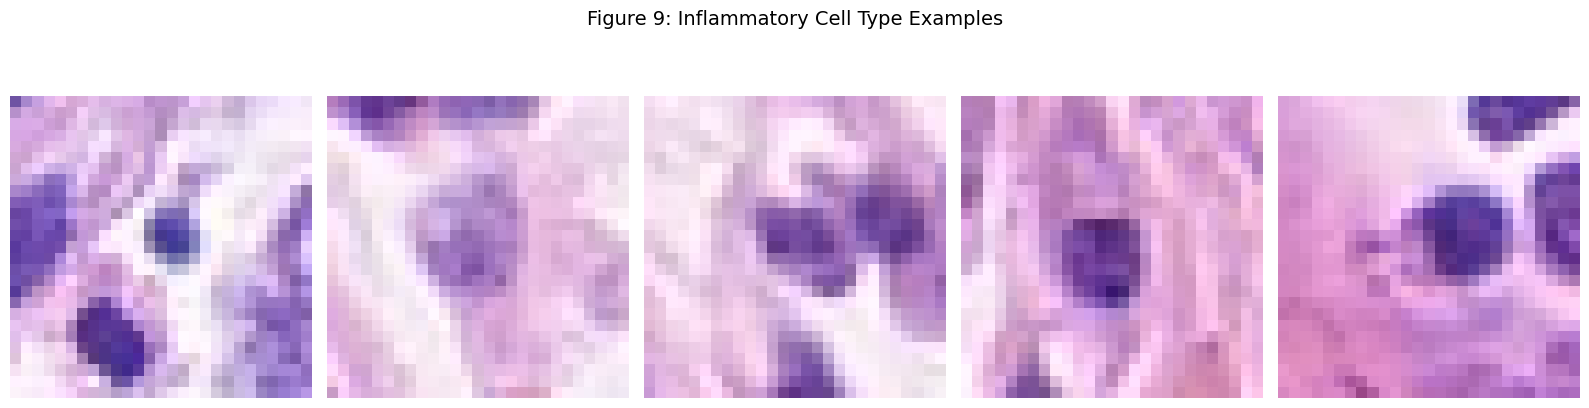

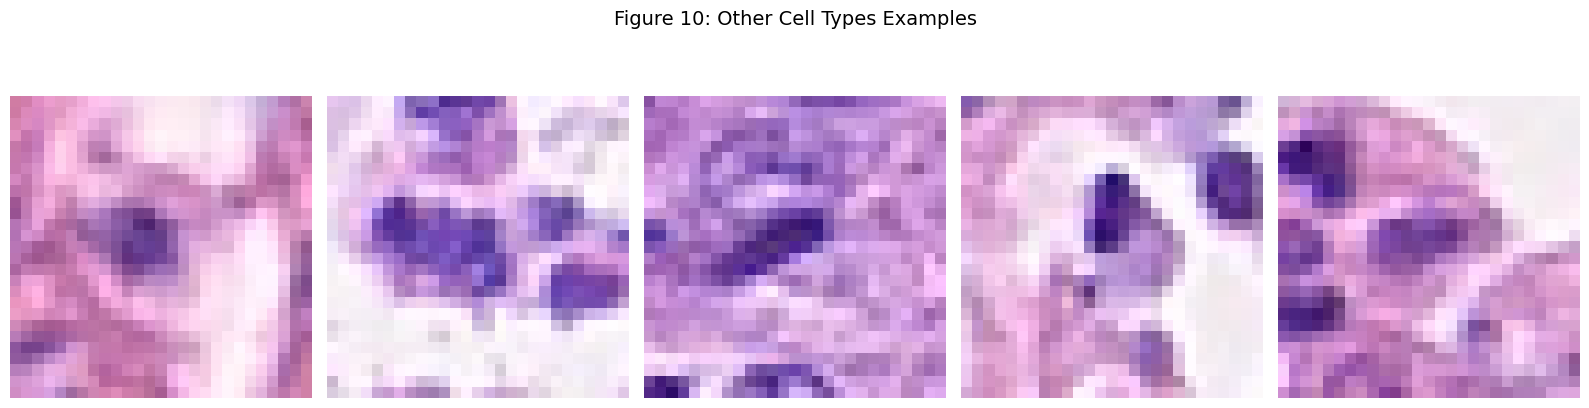

---

In [8]:
# == EDA ==

dfMain = pd.read_csv("Image_classification_data/data_labels_mainData.csv")
dfExtra = pd.read_csv("Image_classification_data/data_labels_extraData.csv")

# Overview
display(Markdown("---"))
display(Markdown("## Table 1: Main Data"))
print("Rows:", dfMain.shape[0], "\tColumns:", dfMain.shape[1])
display(dfMain.head())

display(Markdown("## Table 2: Extra Data"))
print("Rows:", dfExtra.shape[0], "\tColumns:", dfExtra.shape[1])
display(dfExtra.head())
display(Markdown("---"))

# Create figure with 3 subplots in 1 row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Main isCancerous
bar_plot_sub(axes[0], dfMain['isCancerous'],
             title="Figure 1: Main Data- Cancerous vs Non-Cancerous",
             labels=['Non-cancerous', 'Cancerous'])

# Main cellTypeName
bar_plot_sub(axes[1], dfMain['cellTypeName'],
             title="Figure 2: Main Data - Cell Type Distribution")

# Extra isCancerous
bar_plot_sub(axes[2], dfExtra['isCancerous'],
             title="Figure 3: Extra Data – Cancerous vs Non-Cancerous",
             labels=['Non-cancerous', 'Cancerous'])

plt.tight_layout()
plt.show()

# Cross-tab and grouped bar
crosstab = pd.crosstab(dfMain['isCancerous'], dfMain['cellTypeName'])
group_bar(crosstab,
          title="Figure 4: Main Data - Cell Types by Cancerous Status",
          labels=['Non-cancerous', 'Cancerous'])

# Subsets by label
cancerous = dfMain[dfMain['isCancerous'] == 1]
benign = dfMain[dfMain['isCancerous'] == 0]
epithelial = dfMain[dfMain['cellTypeName'] == 'epithelial']
fibroblast = dfMain[dfMain['cellTypeName'] == 'fibroblast']
others = dfMain[dfMain['cellTypeName'] == 'others']
inflammatory = dfMain[dfMain['cellTypeName'] == 'inflammatory']

# Display image samples
show_images_group(cancerous, 5, "Sample Images of Cancerous Cells", figure_num=5)
show_images_group(benign, 5, "Sample Images of Non-Cancerous Cells", figure_num=6)
show_images_group(epithelial, 5, "Epithelial Cell Type Examples", figure_num=7)
show_images_group(fibroblast, 5, "Fibroblast Cell Type Examples", figure_num=8)
show_images_group(inflammatory, 5, "Inflammatory Cell Type Examples", figure_num=9)
show_images_group(others, 5, "Other Cell Types Examples", figure_num=10)

display(Markdown("---"))

## Appendix 2: Model Results

62/62 [==============================] - 0s 4ms/step


### Figure 10: ROC Curves for B-Models

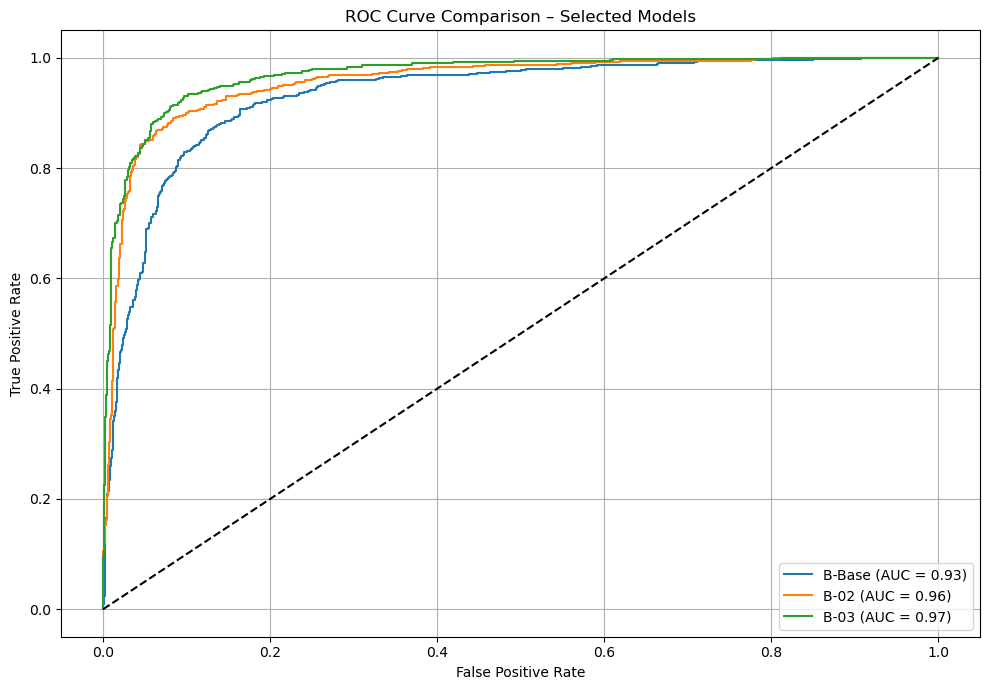

### Figure 11: Learning Curves for B-Models

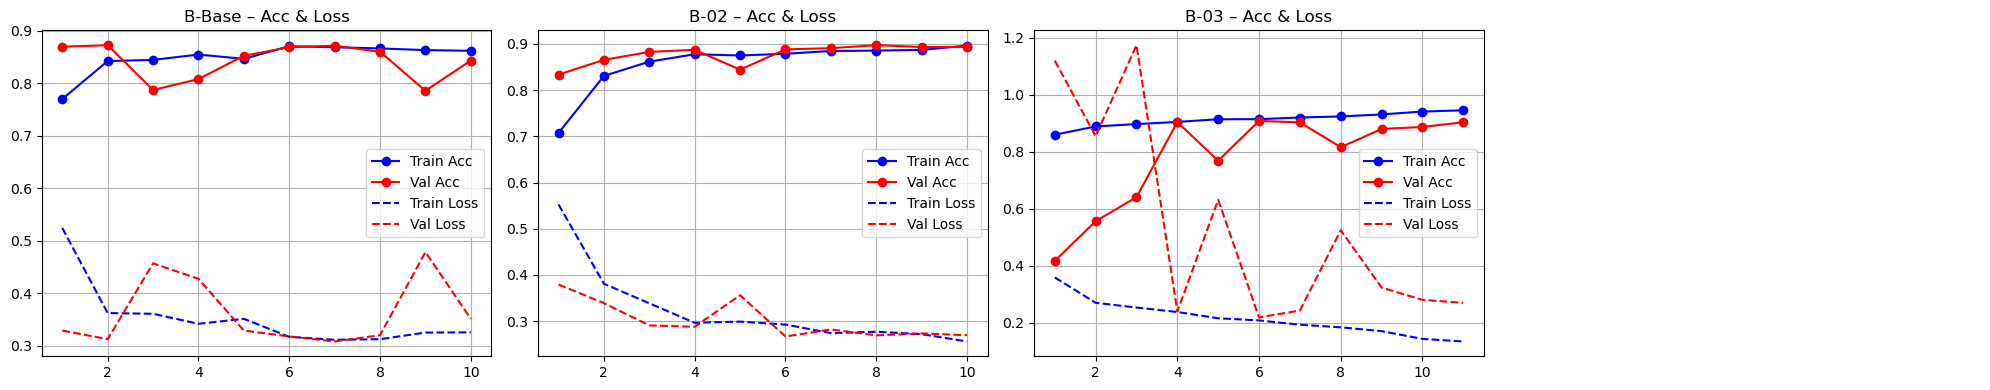

### Table 12: B-Model Results Table with Highlighted Best Test F1

,Name,Model Description,Training F1,Test F1
0,B-Base,"NN, 2 Layers, 64 Neurons",0.859000,0.845000
1,B-02,"CNN, 3 Conv Layers (32, 64, 128), Dense(64), MaxPooling, Class Weights, EarlyStopping",0.903000,0.891000
2,B-03,"CNN, 3 Conv Layers (32, 64, 128) + BatchNorm, Dense(64), MaxPooling, Class Weights, EarlyStopping",0.927000,0.916000


In [12]:
# == VISUALISATIONS FOR B MODELS ==
fig_counter = 10 

# B models
b_results_table, roc_predictions, learning_histories = train_b_models(
    b_model_configs, X_train, y_train, X_val, y_val, X_test, y_test
)

display(Markdown(f"### Figure {fig_counter}: ROC Curves for B-Models"))
plot_roc_curves(roc_predictions, y_test)
fig_counter += 1

display(Markdown(f"### Figure {fig_counter}: Learning Curves for B-Models"))
plot_all_learning_curves(learning_histories)
fig_counter += 1

display(Markdown(f"### Table {fig_counter}: B-Model Results Table with Highlighted Best Test F1"))
display(b_results_table.style.highlight_max(subset=["Test F1"], color="lightgreen"))
fig_counter += 1

[M-01] Best L2 from grid search: 1e-05


### Figure 17: Confusion Matrices for M-Models

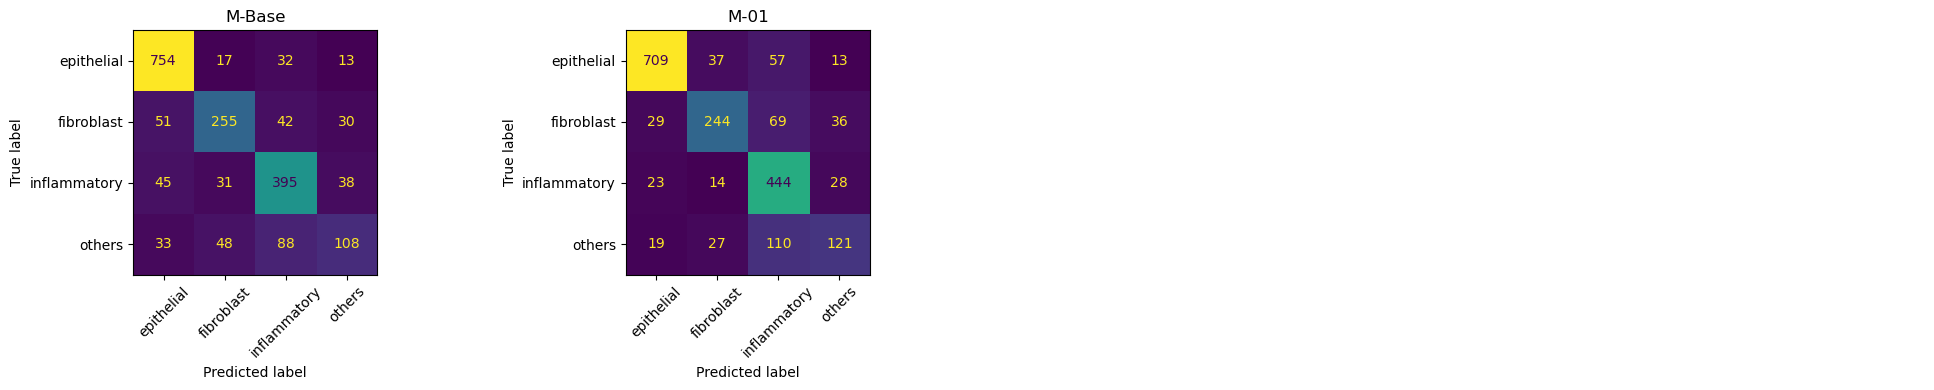

### Figure 18: Multiclass ROC Curves for M-Models

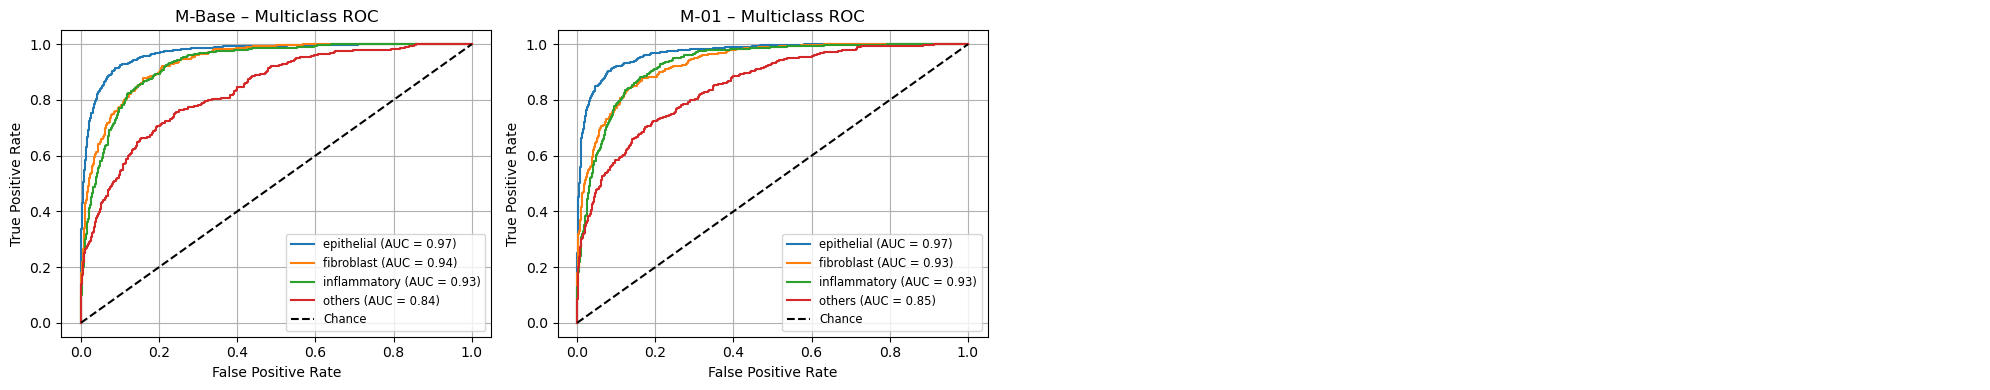

### Figure 19: Learning Curves for M-Models

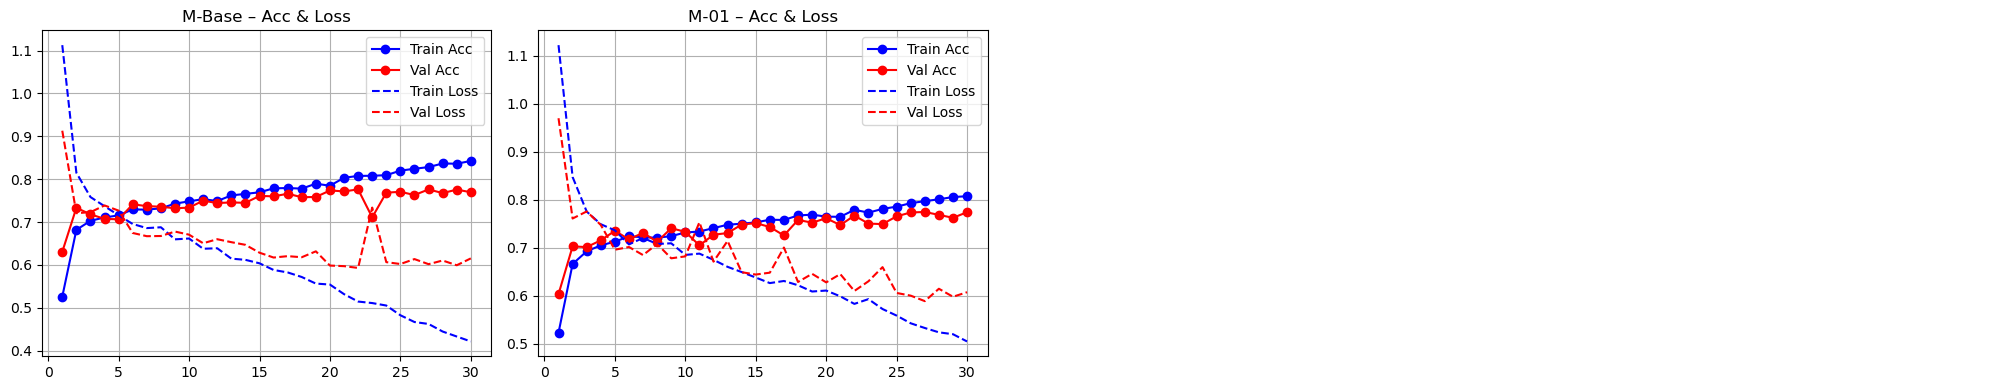

### Table 20: M-Model Results Table with Highlighted Best Test F1

,Name,Model Description,Training F1,Test F1
0,M-Base,"CNN, 3 Conv Layers (32, 64, 128)",0.859000,0.755000
1,M-01,"CNN, 3 Conv Layers (32, 64, 128), EarlyStop, L2 (grid-search), Post Flatten Dropout (0.3)",0.820000,0.763000


In [14]:
# == VISUALISATIONS FOR M MODELS ==
conf_preds, roc_preds, m_histories, m_results_table = train_cell_cnn_models(cell_cnn_configs)

display(Markdown(f"### Figure {fig_counter}: Confusion Matrices for M-Models"))
plot_confusion_matrices(conf_preds, class_names=cell_class_names)
fig_counter += 1

display(Markdown(f"### Figure {fig_counter}: Multiclass ROC Curves for M-Models"))
plot_multiclass_roc(roc_preds, class_names=cell_class_names)
fig_counter += 1

display(Markdown(f"### Figure {fig_counter}: Learning Curves for M-Models"))
plot_all_learning_curves(m_histories)
fig_counter += 1

display(Markdown(f"### Table {fig_counter}: M-Model Results Table with Highlighted Best Test F1"))
display(m_results_table.style.highlight_max(subset=["Test F1"], color="lightgreen"))
fig_counter += 1

## Appendix 3: References

- Alom, Z., Asari, V. K., Parwani, A., & Taha, T. M. (2022). *Microscopic nuclei classification, segmentation, and detection with improved deep convolutional neural networks (DCNN)*. Diagnostic Pathology, 17(1). [https://doi.org/10.1186/s13000-022-01189-5](https://doi.org/10.1186/s13000-022-01189-5)

- Archimbaud, E. (2023). *Programming image classification with machine learning*. Kili Technology. [https://kili-technology.com/data-labeling/computer-vision/imageannotation/programming-image-classification-with-machine-learning](https://kili-technology.com/data-labeling/computer-vision/imageannotation/programming-image-classification-with-machine-learning)

- Brownlee, J. (2020). *Tour of evaluation metrics for imbalanced classification*. Machine Learning Mastery. [https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)

- Huang, Z., Sang, Y., Sun, Y., & Lv, J. (2022). *A neural network learning algorithm for highly imbalanced data classification*. Information Sciences, 612, 496–513. [https://doi.org/10.1016/j.ins.2022.08.074](https://doi.org/10.1016/j.ins.2022.08.074)

- Kavitha, M. S., Kumar, S. S., Prasanna, J., & Ilayaraja, M. (2022). *Deep neural network models for colon cancer screening*. Cancers. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9367621/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9367621/)

- Sirinukunwattana, K., Raza, S. E. A., Tsang, Y. W., Snead, D. R. J., Cree, I. A., & Rajpoot, N. M. (2016). *Locality sensitive deep learning for detection and classification of nuclei in routine colon cancer histology images*. IEEE Transactions on Medical Imaging, 35(5), 1196–1206. [https://doi.org/10.1109/TMI.2016.2525803](https://doi.org/10.1109/TMI.2016.2525803)


### You can add any other analysis you want with justification here (adding code and markdown)